# Generate EKF C-code from Dynamic System Model

In [33]:
# Generate and Compile C Code
%run generate_ekf.py

import os
import subprocess
import ctypes
import numpy as np
import importlib
importlib.reload(ctypes)
importlib.reload(subprocess)

# Compile C code and create library

# https://cu7ious.medium.com/how-to-use-dynamic-libraries-in-c-46a0f9b98270
path = os.path.abspath('c_code')
# Remove old library
subprocess.call('rm -f *.so', shell=True, cwd=path)
subprocess.call('rm -f *.o', shell=True, cwd=path)
# Compile object files
subprocess.call('gcc -fPIC -c *.c common/*.c -Icommon', shell=True, cwd=path)
# Create library
subprocess.call('gcc -shared -Wl,-soname,libtools.so -o libtools.so *.o', shell=True, cwd=path)
# Remove object files
# subprocess.call('rm *.o', shell=True, cwd=path)

lib_path = os.path.abspath("c_code/libtools.so")
lib = ctypes.CDLL(lib_path)

# define argument types 
lib.ekf_set_Q.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_R.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_X.argtypes = [ctypes.POINTER(ctypes.c_float)]
lib.ekf_set_P_diag.argtypes = [ctypes.POINTER(ctypes.c_float)]

lib.ekf_get_X.restype = ctypes.POINTER(ctypes.c_float)
lib.ekf_get_P.restype = ctypes.POINTER(ctypes.c_float)

lib.ekf_predict.argtypes = [ctypes.POINTER(ctypes.c_float), ctypes.c_float]
lib.ekf_update.argtypes = [ctypes.POINTER(ctypes.c_float)]

ekf_use_quat = ctypes.c_bool.in_dll(lib, "ekf_use_quat")

PREDICTION:
CSE
SIMPLIFY
CCODE
S and PHT MATRICES FOR SOLVING K:
CSE
SIMPLIFY
CCODE
UPDATE:
CSE
SIMPLIFY
CCODE


<Figure size 640x480 with 0 Axes>

# Test C code

In [34]:
import csv
import numpy as np

def load_flight_data(file_name):
    with open(file_name) as file:
        reader = csv.reader(file)
        data = list(reader)
        
        # separate header and data
        header = [d for d in data if len(d)==2]
        header = {d[0]: d[1] for d in header}
        
        data = [d for d in data if len(d)>2]
        keys = data[0]
        data = data[1:]
        data = np.array([[float(d) if d else np.nan for d in row] for row in data]) # set empty strings to nan
        data = dict(zip(keys,data.T))
        
        # renaming keys
        data['t'] = data.pop('time')*1e-6 # us to s
        data['t'] -= data['t'][0] # start at 0

        # state estimate
        data['x'] = data.pop('pos[0]')*1e-3 # mm to m
        data['y'] = data.pop('pos[1]')*1e-3 # mm to m
        data['z'] = data.pop('pos[2]')*1e-3 # mm to m
        
        data['vx'] = data.pop('vel[0]')*1e-2 # cm/s to m/s
        data['vy'] = data.pop('vel[1]')*1e-2 # cm/s to m/s
        data['vz'] = data.pop('vel[2]')*1e-2 # cm/s to m/s
        
        quat_scaling = ((127 << 6) - 1) # float from -1 to +1 to VB that takes up 2 bytes max
        data['qw'] = data.pop('quat[0]')/quat_scaling
        data['qx'] = data.pop('quat[1]')/quat_scaling
        data['qy'] = data.pop('quat[2]')/quat_scaling
        data['qz'] = data.pop('quat[3]')/quat_scaling
        
        # quat to eulers
        data['phi'] = np.arctan2(2*(data['qw']*data['qx'] + data['qy']*data['qz']), 1 - 2*(data['qx']**2 + data['qy']**2))
        data['theta'] = np.arcsin(2*(data['qw']*data['qy'] - data['qz']*data['qx']))
        data['psi'] = np.arctan2(2*(data['qw']*data['qz'] + data['qx']*data['qy']), 1 - 2*(data['qy']**2 + data['qz']**2))
        
        
        # optitrack
        data['x_opti'] = data.pop('extPos[0]')*1e-3 # mm to m
        data['y_opti'] = data.pop('extPos[1]')*1e-3 # mm to m
        data['z_opti'] = data.pop('extPos[2]')*1e-3 # mm to m
        
        data['vx_opti'] = data.pop('extVel[0]')*1e-2 # cm/s to m/s
        data['vy_opti'] = data.pop('extVel[1]')*1e-2 # cm/s to m/s
        data['vz_opti'] = data.pop('extVel[2]')*1e-2 # cm/s to m/s
        
        data['phi_opti'] = data.pop('extAtt[0]')/1000 # mrad to rad
        data['theta_opti'] = data.pop('extAtt[1]')/1000 # mrad to rad
        data['psi_opti'] = data.pop('extAtt[2]')/1000 # mrad to rad
        
        # imu (from FLU to FRD)
        gyro_scale = np.pi/180 # deg/s to rad/s
        if bool(float(header['blackbox_high_resolution'])):
            gyro_scale /= 10
        data['p'] = data.pop('gyroADC[0]')*gyro_scale
        data['q'] =-data.pop('gyroADC[1]')*gyro_scale
        data['r'] =-data.pop('gyroADC[2]')*gyro_scale
        
        acc_scale = 9.81/float(header['acc_1G'])
        data['ax'] = data.pop('accSmooth[0]')*acc_scale
        data['ay'] =-data.pop('accSmooth[1]')*acc_scale
        data['az'] =-data.pop('accSmooth[2]')*acc_scale
        
        # onboard ekf
        data['ekf_x'] = data.pop('ekf_pos[0]')*1e-3 # mm to m
        data['ekf_y'] = data.pop('ekf_pos[1]')*1e-3 # mm to m
        data['ekf_z'] = data.pop('ekf_pos[2]')*1e-3 # mm to m
        data['ekf_vx'] = data.pop('ekf_vel[0]')*1e-2 # cm/s to m/s
        data['ekf_vy'] = data.pop('ekf_vel[1]')*1e-2 # cm/s to m/s
        data['ekf_vz'] = data.pop('ekf_vel[2]')*1e-2 # cm/s to m/s
        data['ekf_phi'] = data.pop('ekf_att[0]')/1000 # mrad to rad
        data['ekf_theta'] = data.pop('ekf_att[1]')/1000 # mrad to rad
        data['ekf_psi'] = data.pop('ekf_att[2]')/1000 # mrad to rad
        data['ekf_acc_b_x'] = data.pop('ekf_acc_b[0]')/1000 # mm/s^2 to m/s^2
        data['ekf_acc_b_y'] = data.pop('ekf_acc_b[1]')/1000 # mm/s^2 to m/s^2
        data['ekf_acc_b_z'] = data.pop('ekf_acc_b[2]')/1000 # mm/s^2 to m/s^2
        data['ekf_gyro_b_x'] = data.pop('ekf_gyro_b[0]')*np.pi/180
        data['ekf_gyro_b_y'] = data.pop('ekf_gyro_b[1]')*np.pi/180
        data['ekf_gyro_b_z'] = data.pop('ekf_gyro_b[2]')*np.pi/180
                
        return data

logging frequency: 504.02061046270694 Hz
optitrack frequency: 21.201325353867094 Hz


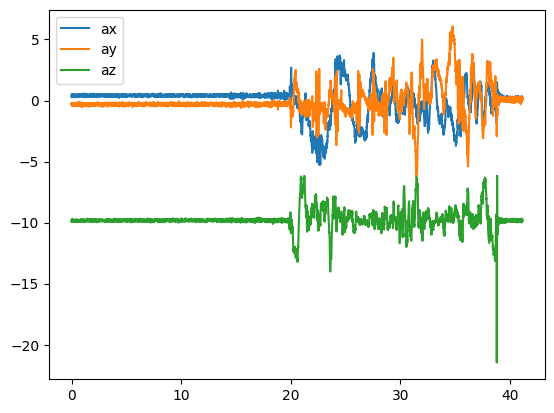

In [35]:
import matplotlib.pyplot as plt

#data = np.load('ekf_data_6may_8ms_delay.npz')
data = load_flight_data('EKF_logging_test8.csv')
    
# logging frequency
freq = 1/np.mean(np.diff(data['t']))
print('logging frequency:',freq,'Hz')

# optitrack frequency
opti_updates = (np.gradient(data['x_opti'])!=0) | (np.gradient(data['y_opti'])!=0) | (np.gradient(data['z_opti'])!=0)
opti_freq = 1/np.mean(np.diff(data['t'][opti_updates]))
print('optitrack frequency:',opti_freq,'Hz')

# plot ax, ay, az
# clos all plots
%matplotlib inline
plt.close('all')
plt.plot(data['t'],data['ax'],label='ax')
plt.plot(data['t'],data['ay'],label='ay')
plt.plot(data['t'],data['az'],label='az')
plt.legend()
plt.show()

In [36]:
# EKF INPUT: U = [ax, ay, az, p, q, r] (IMU)
U_data = np.array([
    data['ax'], data['ay'], data['az'], data['p'], data['q'], data['r']
]).T

# EKF MEASUREMENT: Z = [x, y, z, qw, qx, qy, qz] (Optitrack)
Z_data = np.array([
    data['x_opti'], data['y_opti'], data['z_opti'], data['qw'], data['qx'], data['qy'], data['qz']
]).T

# SHIFT Z data by 3 samples
shift = 3
Z_data_shift = np.roll(Z_data, -shift, axis=0)
# Z_data = Z_data_shift

print(shift)


t = data['t']
delay = np.mean(t[shift:]-t[:-shift])
('delay:',delay,'s')

3


('delay:', 0.005952137560270009, 's')

In [37]:
# INITIALIZE EKF
# initial state
lenX = 16
X_init = np.zeros(lenX)
X_init[:3] = Z_data[0,:3]
a = -72. * np.pi / 180.
X_init[6] = np.cos(0.5*a)
X_init[7] = 0.0
X_init[8] = 0.0
X_init[9] = np.sin(0.5*a)
# X_init[12:15] = [p_bias, q_bias, r_bias]

ekf_use_quat.value = True

# initial covariance
P_init = np.array([1.]*lenX)
#P_init[9] = 10. # initial heading covarinace
P_init[-6:-3] = 1e-2 # set accel bias covariance
P_init[-3:] = 1e-2 # set gyro bias covariance. 
P_init[-3:] *= (ekf_use_quat.value) # do not estimate bias if no heading measurement
# print(P_init)

# process noise covariance
#Q_diag = np.array([0.5, 0.5, 0.5, 0.01, 0.01, 0.01, 1e-5, 1e-5, 1e-5, 0, 0, 0])
Q_diag = np.array([0.5, 0.5, 0.5, 0.1, 0.1, 0.1, 1e-4, 1e-4, 1e-4, 1e-5, 1e-5, 1e-5])
Q_diag[-3:] *= (ekf_use_quat.value)

# measurement noise covariance
R_diag = np.array([0.005, 0.005, 0.005, .05, .05, .05, .05])

lib.ekf_set_Q((ctypes.c_float*len(Q_diag))(*Q_diag))
lib.ekf_set_R((ctypes.c_float*len(R_diag))(*R_diag))
lib.ekf_set_X((ctypes.c_float*len(X_init))(*X_init))
lib.ekf_set_P_diag((ctypes.c_float*len(P_init))(*P_init))


# test ekf_get_state
x = lib.ekf_get_X()
x = np.array([x[i] for i in range(lenX)])
print(x)

# RUN EKF
X_ekf = [X_init]
P_ekf = [np.array([1.])*int(lenX*(lenX+1)/2)]

X_sampled = []
X_delayed = []
X_shift =[]
m_idx =[]

for i in range(1, len(t)):
    # PREDICT
    lib.ekf_predict(
        (ctypes.c_float*len(U_data[i]))(*U_data[i]),
        ctypes.c_float(t[i]-t[i-1])
    )
    
    # UPDATE
    # only update when there is a new measurement
    if np.any(Z_data[i]-Z_data[i-1] != 0):
        m_idx.append(i)
        
        # fix yaw
        #while Z_data[i,5]-Z_data[i-1,5] > np.pi:
        #    Z_data[i,5] -= 2*np.pi
        #while Z_data[i,5]-Z_data[i-1,5] < -np.pi:
        #    Z_data[i,5] += 2*np.pi
            
        # # fix delay issue
        # time_delay = 0.008
        # # message time
        # m_time = t[i] - 0.008
        
        # # backwards predict n steps
        # j = 0
        # while t[i-j] > m_time and i-j-1 > 0:
        #     lib.ekf_predict(
        #         (ctypes.c_float*len(U_data[i-j]))(*U_data[i-j]),
        #         ctypes.c_float(-(t[i-j]-t[i-j-1]))                  # negative time step
        #     )
        #     j += 1
        
        # # backwards predict remainder
        # lib.ekf_predict(
        #     (ctypes.c_float*len(U_data[i-j]))(*U_data[i-j]),
        #     ctypes.c_float(-(m_time-t[i-j]))
        # )
        
        # backwards predict
        # lib.ekf_predict(
        #     (ctypes.c_float*len(U_data[i]))(*U_data[i]),
        #     ctypes.c_float(-delay)
        # )
        
        # save X delayed
        # x = lib.ekf_get_X()
        # x = np.array([x[i] for i in range(len(X))])
        # X_delayed.append(x)
        
        
        # update
        lib.ekf_update(
            (ctypes.c_float*len(Z_data[i]))(*Z_data[i])
        )
        
        # forward predict
        # lib.ekf_predict(
        #     (ctypes.c_float*len(U_data[i]))(*U_data[i]),
        #     ctypes.c_float(delay)
        # )
        
        # forward predict remainder
        # lib.ekf_predict(
        #     (ctypes.c_float*len(U_data[i-j-1]))(*U_data[i-j-1]),
        #     ctypes.c_float(-(m_time-t[i-j]))
        # )
        
        # # forward predict n steps
        # for k in range(j):
        #     lib.ekf_predict(
        #         (ctypes.c_float*len(U_data[i-j+k]))(*U_data[i-j+k]),
        #         ctypes.c_float(t[i-j+k+1]-t[i-j+k])
        #     )
        #break;
        
        
        
    # get state
    x = lib.ekf_get_X()
    x = np.array([x[i] for i in range(lenX)])
    X_ekf.append(x)
    
    # get Pdiag
    P = lib.ekf_get_P()
    P = np.array([P[i] for i in range(int(lenX*(lenX+1)/2))])
    P_ekf.append(P)
    print(P[[int(i*(i+1)/2 + i) for i in range(13,16)]])


[-3.97900009 -0.52200001  0.009       0.          0.          0.
  0.809017    0.          0.         -0.58778524  0.          0.
  0.          0.          0.          0.        ]
[0.01 0.01 0.01]
[0.01 0.01 0.01]
[0.01 0.01 0.01]
[0.01 0.01 0.01]
[0.01 0.01 0.01]
[0.01 0.01 0.01]
[0.01 0.01 0.01]
[0.01 0.01 0.01]
[0.01 0.01 0.01]
[0.01 0.01 0.01]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.00999995 0.00999995]
[0.00999995 0.009999

In [38]:
X_ekf_corrected =  np.array(X_ekf)
X_ekf_normal = np.array(X_ekf)
X_ekf_Zshift = np.array(X_ekf)

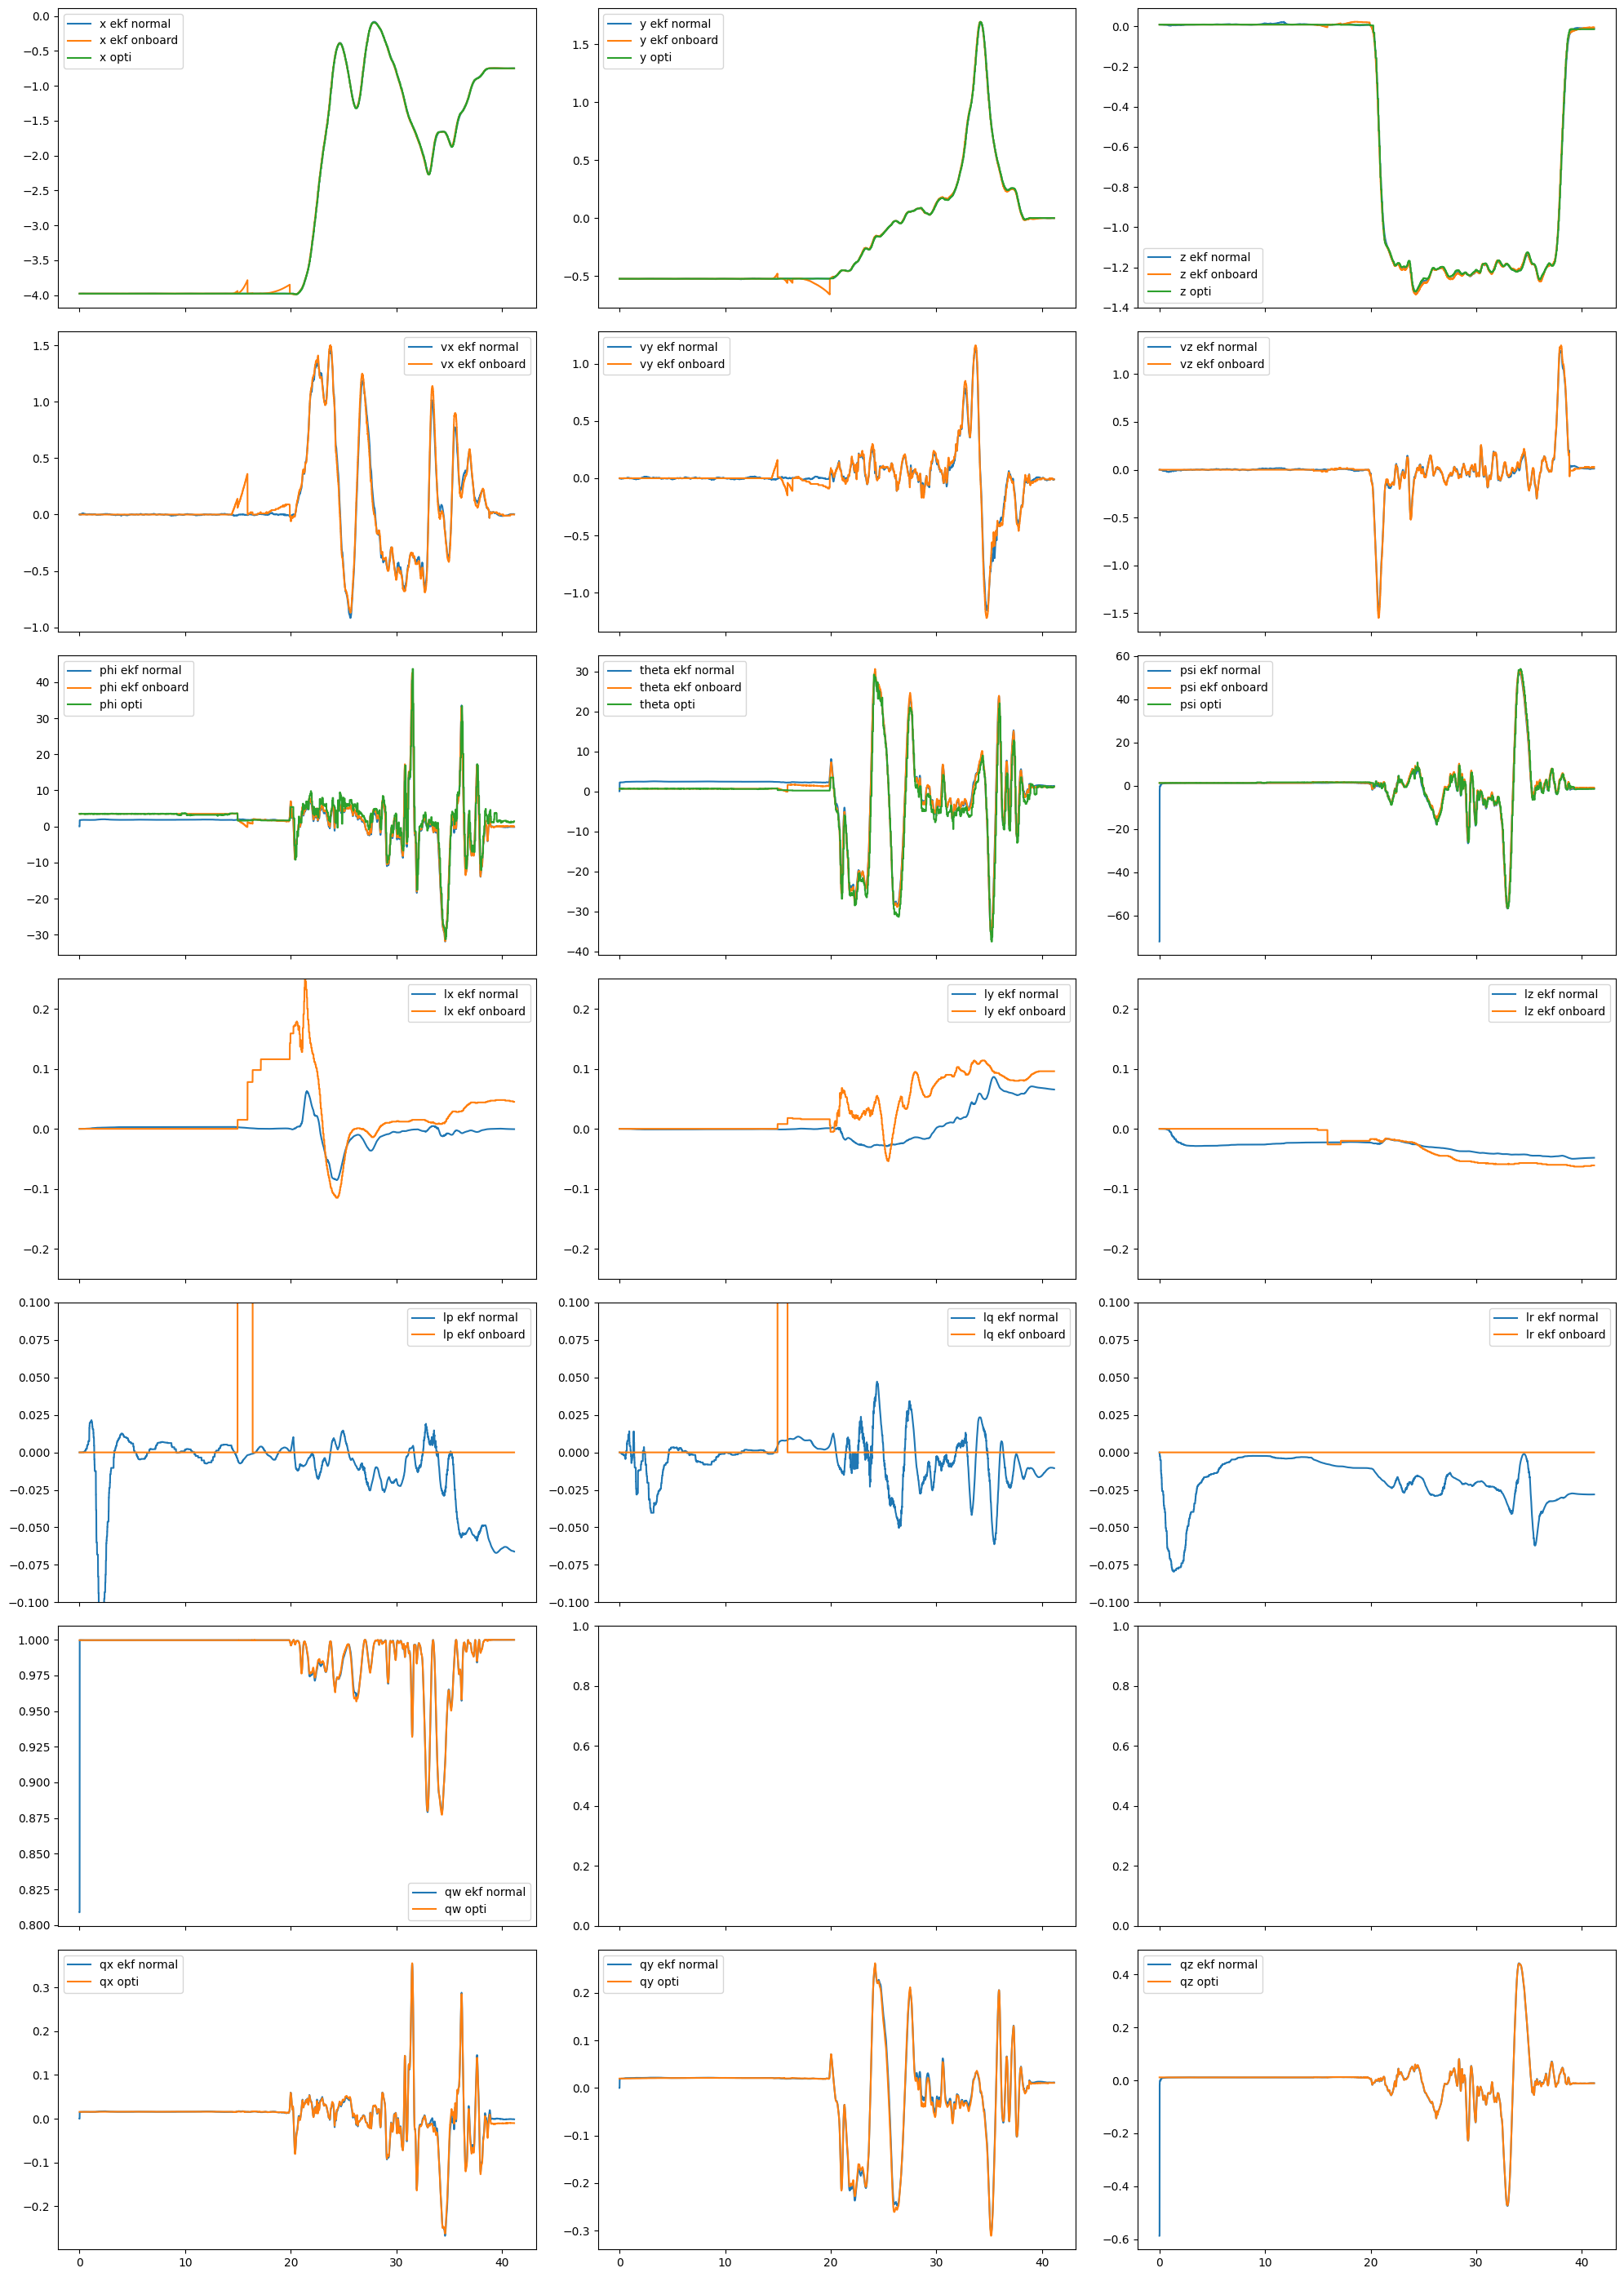

In [39]:
# plot trajectory
#%matplotlib
X_ekf = np.array(X_ekf)
# Pdiag_ekf = np.array(Pdiag_ekf)


# 5x3 subplots
fig, axs = plt.subplots(7, 3, figsize=(20,7/5*20), tight_layout=True, sharex=True)
axs = axs.flatten()

# position
axs[0].plot(t, X_ekf_normal[:,0], label='x ekf normal')
# axs[0].plot(t, X_ekf_Zshift[:,0], label='x ekf Zshift')
# axs[0].plot(t, X_ekf_corrected[:,0], label='x ekf corrected')
axs[0].plot(t, data['ekf_x'], label='x ekf onboard')
axs[0].plot(t, data['x_opti'], label='x opti')
axs[0].legend()


axs[1].plot(t, X_ekf_normal[:,1], label='y ekf normal')
# axs[1].plot(t, X_ekf_Zshift[:,1], label='y ekf Zshift')
# axs[1].plot(t, X_ekf_corrected[:,1], label='y ekf corrected')
axs[1].plot(t, data['ekf_y'], label='y ekf onboard')
axs[1].plot(t, data['y_opti'], label='y opti')
axs[1].legend()

axs[2].plot(t, X_ekf_normal[:,2], label='z ekf normal')
# axs[2].plot(t, X_ekf_Zshift[:,2], label='z ekf Zshift')
# axs[2].plot(t, X_ekf_corrected[:,2], label='z ekf corrected')
axs[2].plot(t, data['ekf_z'], label='z ekf onboard')
axs[2].plot(t, data['z_opti'], label='z opti')
axs[2].legend()

# velocity
axs[3].plot(t, X_ekf_normal[:,3], label='vx ekf normal')
# axs[3].plot(t, X_ekf_Zshift[:,3], label='vx ekf Zshift')
# axs[3].plot(t, X_ekf_corrected[:,3], label='vx ekf corrected')
axs[3].plot(t, data['ekf_vx'], label='vx ekf onboard')
axs[3].legend()

axs[4].plot(t, X_ekf_normal[:,4], label='vy ekf normal')
# axs[4].plot(t, X_ekf_Zshift[:,4], label='vy ekf Zshift')
# axs[4].plot(t, X_ekf_corrected[:,4], label='vy ekf corrected')
axs[4].plot(t, data['ekf_vy'], label='vy ekf onboard')
axs[4].legend()

axs[5].plot(t, X_ekf_normal[:,5], label='vz ekf normal')
# axs[5].plot(t, X_ekf_Zshift[:,5], label='vz ekf Zshift')
# axs[5].plot(t, X_ekf_corrected[:,5], label='vz ekf corrected')
axs[5].plot(t, data['ekf_vz'], label='vz ekf onboard')
axs[5].legend()

# attitude
rad_to_deg = 180/np.pi
from scipy.spatial.transform import Rotation
eulers = Rotation.from_quat(X_ekf_normal[:, [7, 8, 9, 6]]).as_euler('xyz', degrees=False)

axs[6].plot(t, rad_to_deg*eulers[:,0], label='phi ekf normal')
# axs[6].plot(t, rad_to_deg*X_ekf_Zshift[:,6], label='phi ekf Zshift')
# axs[6].plot(t, rad_to_deg*X_ekf_corrected[:,6], label='phi ekf corrected')
axs[6].plot(t, rad_to_deg*data['ekf_phi'], label='phi ekf onboard')
axs[6].plot(t, rad_to_deg*data['phi_opti'], label='phi opti')
axs[6].legend()

axs[7].plot(t, rad_to_deg*eulers[:,1], label='theta ekf normal')
# axs[7].plot(t, rad_to_deg*X_ekf_Zshift[:,7], label='theta ekf Zshift')
# axs[7].plot(t, rad_to_deg*X_ekf_corrected[:,7], label='theta ekf corrected')
axs[7].plot(t, rad_to_deg*data['ekf_theta'], label='theta ekf onboard')
axs[7].plot(t, rad_to_deg*data['theta_opti'], label='theta opti')
axs[7].legend()

axs[8].plot(t, rad_to_deg*eulers[:,2], label='psi ekf normal')
# axs[8].plot(t, rad_to_deg*X_ekf_Zshift[:,8], label='psi ekf Zshift')
# axs[8].plot(t, rad_to_deg*X_ekf_corrected[:,8], label='psi ekf corrected')
axs[8].plot(t, rad_to_deg*data['ekf_psi'], label='psi ekf onboard')
axs[8].plot(t, rad_to_deg*data['psi_opti'], label='psi opti')
axs[8].legend()

# biases
axs[9].plot(t, X_ekf_normal[:,10], label='lx ekf normal')
# axs[9].plot(t, X_ekf_Zshift[:,9], label='lx ekf Zshift')
# axs[9].plot(t, X_ekf_corrected[:,9], label='lx ekf corrected')
axs[9].plot(t, data['ekf_acc_b_x'], label='lx ekf onboard')
axs[9].set_ylim([-0.25, 0.25])
axs[9].legend()

axs[10].plot(t, X_ekf_normal[:,11], label='ly ekf normal')
# axs[10].plot(t, X_ekf_Zshift[:,10], label='ly ekf Zshift')
# axs[10].plot(t, X_ekf_corrected[:,10], label='ly ekf corrected')
axs[10].plot(t, data['ekf_acc_b_y'], label='ly ekf onboard')
axs[10].set_ylim([-0.25, 0.25])
axs[10].legend()

axs[11].plot(t, X_ekf_normal[:,12], label='lz ekf normal')
# axs[11].plot(t, X_ekf_Zshift[:,11], label='lz ekf Zshift')
# axs[11].plot(t, X_ekf_corrected[:,11], label='lz ekf corrected')
axs[11].plot(t, data['ekf_acc_b_z'], label='lz ekf onboard')
axs[11].set_ylim([-0.25, 0.25])
axs[11].legend()

axs[12].plot(t, rad_to_deg*X_ekf_normal[:,13], label='lp ekf normal')
# axs[12].plot(t, rad_to_deg*X_ekf_Zshift[:,12], label='lp ekf Zshift')
# axs[12].plot(t, rad_to_deg*X_ekf_corrected[:,12], label='lp ekf corrected')
axs[12].plot(t, rad_to_deg*data['ekf_gyro_b_x'], label='lp ekf onboard')
axs[12].set_ylim([-0.1, 0.1])
axs[12].legend()

axs[13].plot(t, rad_to_deg*X_ekf_normal[:,14], label='lq ekf normal')
# axs[13].plot(t, rad_to_deg*X_ekf_Zshift[:,13], label='lq ekf Zshift')
# axs[13].plot(t, rad_to_deg*X_ekf_corrected[:,13], label='lq ekf corrected')
axs[13].plot(t, rad_to_deg*data['ekf_gyro_b_y'], label='lq ekf onboard')
axs[13].set_ylim([-0.1, 0.1])
axs[13].legend()

axs[14].plot(t, rad_to_deg*X_ekf_normal[:,15], label='lr ekf normal')
# axs[14].plot(t, rad_to_deg*X_ekf_Zshift[:,14], label='lr ekf Zshift')
# axs[14].plot(t, rad_to_deg*X_ekf_corrected[:,14], label='lr ekf corrected')
axs[14].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='lr ekf onboard')
axs[14].set_ylim([-0.1, 0.1])
axs[14].legend()

axs[15].plot(t, X_ekf_normal[:,6], label='qw ekf normal')
#axs[15].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qw ekf onboard')
axs[15].plot(t, data['qw'], label='qw opti')
axs[15].legend()

axs[18].plot(t, X_ekf_normal[:,7], label='qx ekf normal')
#axs[18].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qx ekf onboard')
axs[18].plot(t, data['qx'], label='qx opti')
axs[18].legend()

axs[19].plot(t, X_ekf_normal[:,8], label='qy ekf normal')
#axs[19].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qy ekf onboard')
axs[19].plot(t, data['qy'], label='qy opti')
axs[19].legend()

axs[20].plot(t, X_ekf_normal[:,9], label='qz ekf normal')
#axs[20].plot(t, rad_to_deg*data['ekf_gyro_b_z'], label='qz ekf onboard')
axs[20].plot(t, data['qz'], label='qz opti')
axs[20].legend()

plt.show()

In [40]:
plt.close('all')